In [81]:
import snowflake.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# connection parameters
account = 'rv79164.mexico-central.azure'
user = 'anguiegarcia'
password = 'AnguieCobre_2025'
database = 'my_database'
schema = 'my_schema'
warehouse = 'my_warehouse'
role = 'accountadmin'
threads = 1

# Snowflake connection
conn = snowflake.connector.connect(
    user=user,
    password=password,
    account=account,
    database=database,
    schema=schema,
    warehouse=warehouse,
    role=role
)

# IN_HUBSPOT_LEADS_ENRICHED

In [83]:

sql_query = "SELECT * FROM IN_HUBSPOT_LEADS_ENRICHED;"
df = pd.read_sql(sql_query, conn)
print(f"shape: {df.shape}")
df.head()

C:\Users\BETAN\AppData\Local\Temp\ipykernel_5816\99317036.py:2: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



shape: (8000, 12)


,MQL_ID,FIRST_CONTACT_DATE,LANDING_PAGE_ID,LEAD_SOURCE,SELLER_ID,WON_DATE,DAYS_TO_CONVERSION,IS_WON,BUSINESS_SEGMENT,LEAD_TYPE,BUSINESS_TYPE,LEAD_BEHAVIOUR_PROFILE
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social,None,NaT,NaN,0,None,None,None,None
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search,None,NaT,NaN,0,None,None,None,None
2,b4bc852d233dfefc5131f593b538befa,2018-03-22,a7982125ff7aa3b2054c6e44f9d28522,organic_search,None,NaT,NaN,0,None,None,None,None
3,6be030b81c75970747525b843c1ef4f8,2018-01-22,d45d558f0daeecf3cccdffe3c59684aa,email,None,NaT,NaN,0,None,None,None,None
4,5420aad7fec3549a85876ba1c529bd84,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search,2c43fb513632d29b3b58df74816f1b06,2018-02-26 19:58:54,5.0,1,pet,online_medium,reseller,cat


In [84]:
missing_data = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Total missing': missing_data,
    'Percentage': missing_percentage
})

print(missing_df[missing_df['Total missing'] > 0].sort_values(by='Percentage', ascending=False))

                        Total missing  Percentage
LEAD_BEHAVIOUR_PROFILE           7335     91.6875
WON_DATE                         7158     89.4750
SELLER_ID                        7158     89.4750
DAYS_TO_CONVERSION               7158     89.4750
BUSINESS_SEGMENT                 7158     89.4750
LEAD_TYPE                        7158     89.4750
BUSINESS_TYPE                    7158     89.4750


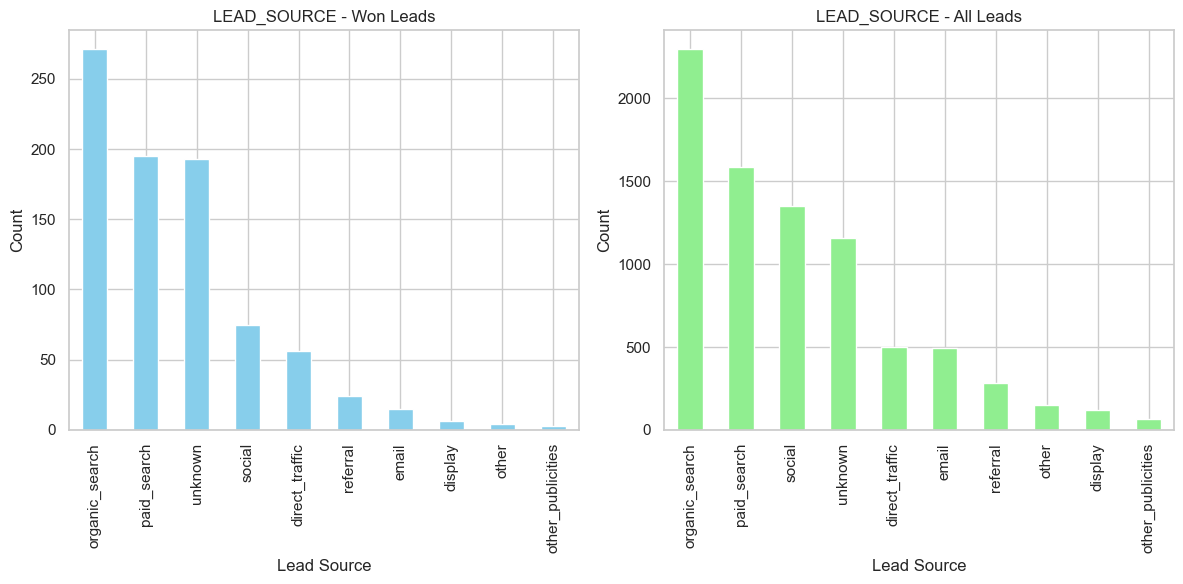

In [85]:
df_won = df[df['WON_DATE'].notna()]

# Create the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# First bar chart: df_won
df_won['LEAD_SOURCE'].value_counts().plot(kind='bar', grid=True, ax=axs[0], color='skyblue')
axs[0].set_title('LEAD_SOURCE - Won Leads')
axs[0].set_xlabel('Lead Source')
axs[0].set_ylabel('Count')

# Second bar chart: df
df['LEAD_SOURCE'].value_counts().plot(kind='bar', grid=True, ax=axs[1], color='lightgreen')
axs[1].set_title('LEAD_SOURCE - All Leads')
axs[1].set_xlabel('Lead Source')
axs[1].set_ylabel('Count')

# Improve layout
plt.tight_layout()
plt.show()

In [86]:
df_won.groupby(df_won['WON_DATE'].dt.month)['LEAD_ID'].count().plot(kind='bar', grid=True)

KeyError: 'Column not found: LEAD_ID'

C:\Users\BETAN\AppData\Local\Temp\ipykernel_404\889636986.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_won['FIRST_CONTACT_DATE'] = pd.to_datetime(df_won['FIRST_CONTACT_DATE'])


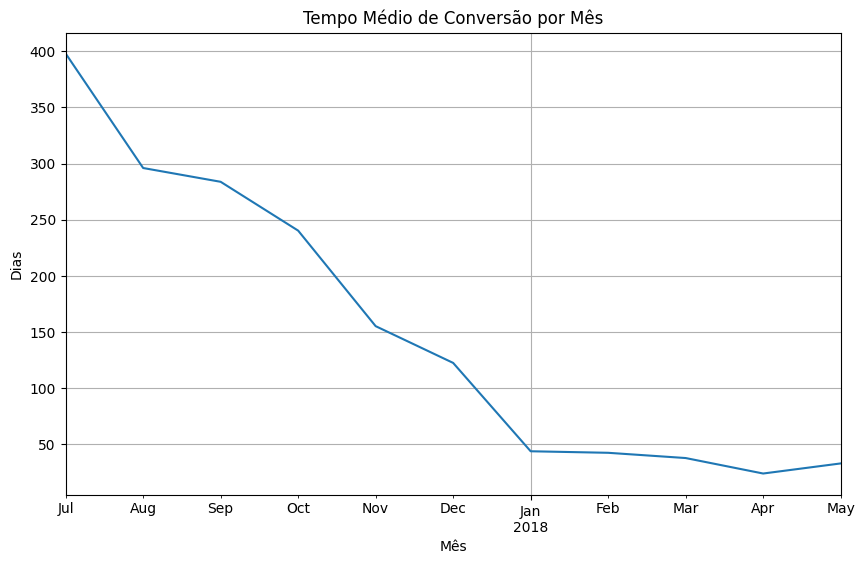

In [ ]:
df_won['FIRST_CONTACT_DATE'] = pd.to_datetime(df_won['FIRST_CONTACT_DATE'])
monthly_conversion = df_won.groupby(df_won['FIRST_CONTACT_DATE'].dt.to_period("M")).mean(numeric_only=True)['DAYS_TO_CONVERSION']

# Plotando
plt.figure(figsize=(10,6))
monthly_conversion.plot()
plt.title('Tempo Médio de Conversão por Mês')
plt.ylabel('Dias')
plt.xlabel('Mês')
plt.grid(True)
plt.show()

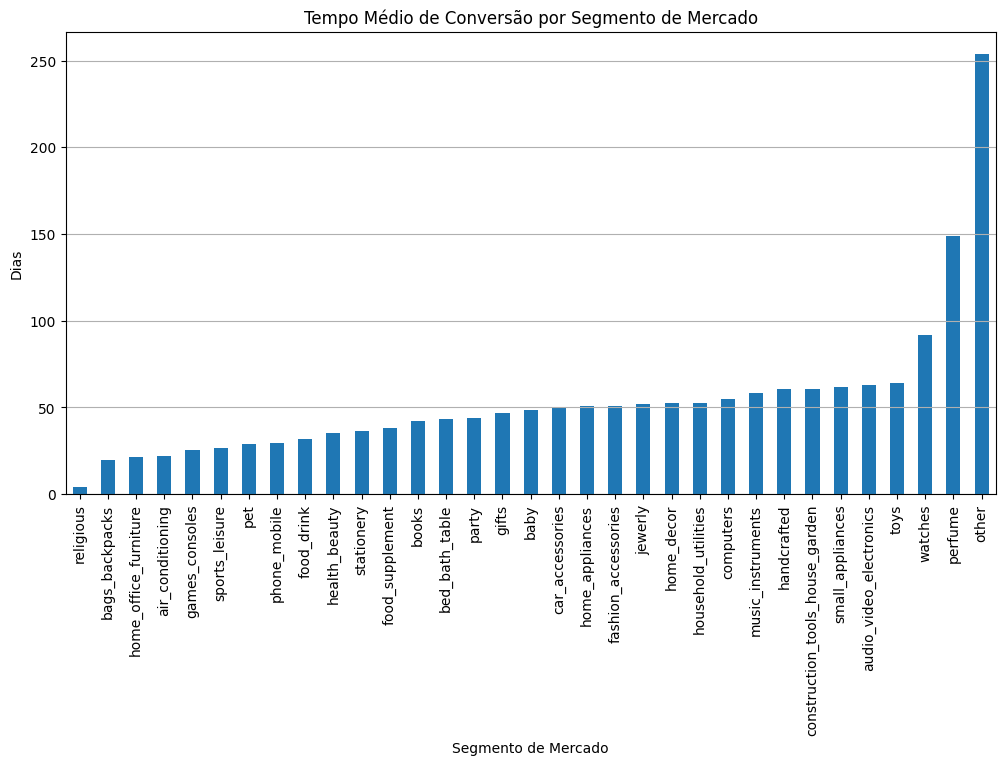

In [ ]:
business_conversion = df_won.groupby('BUSINESS_SEGMENT')['DAYS_TO_CONVERSION'].mean()

business_conversion.sort_values().plot(kind='bar', figsize=(12,6))
plt.title('Tempo Médio de Conversão por Segmento de Mercado')
plt.ylabel('Dias')
plt.xlabel('Segmento de Mercado')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

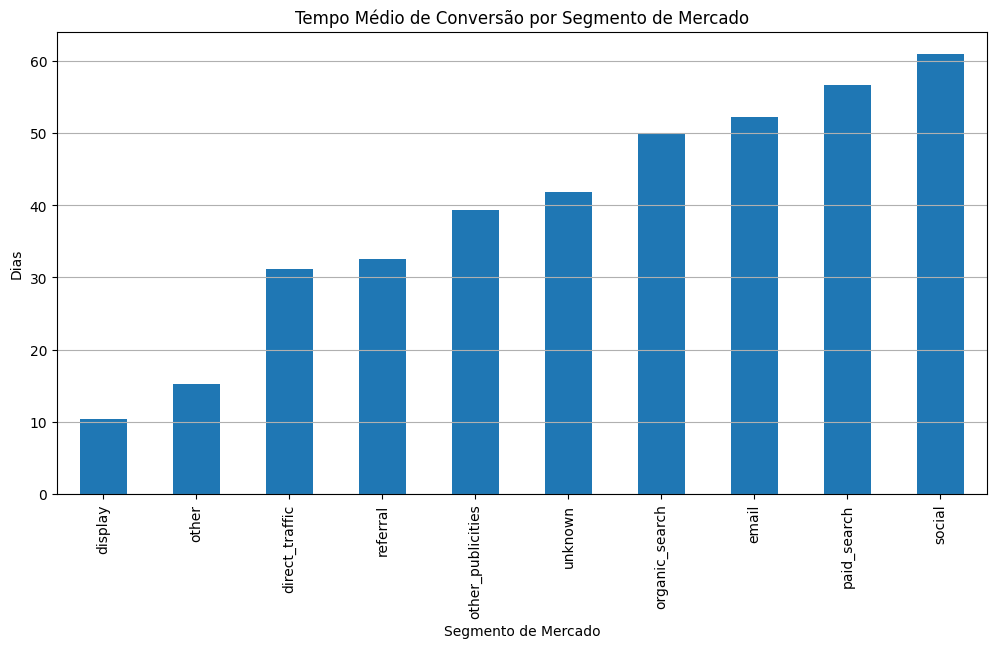

In [ ]:
business_conversion = df_won.groupby('LEAD_SOURCE')['DAYS_TO_CONVERSION'].mean()

business_conversion.sort_values().plot(kind='bar', figsize=(12,6))
plt.title('Tempo Médio de Conversão por Segmento de Mercado')
plt.ylabel('Dias')
plt.xlabel('Segmento de Mercado')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

# mart

In [103]:
sql_query = "SELECT * FROM mart_avg_conversion_time_by_channel_and_type;"
df_avg_conv = pd.read_sql(sql_query, conn)
print(f"shape: {df_avg_conv.shape}")
df_avg_conv.head()

C:\Users\BETAN\AppData\Local\Temp\ipykernel_5816\2794710198.py:2: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



shape: (56, 3)


,LEAD_SOURCE,LEAD_TYPE,AVG_DAYS_TO_CONVERSION
0,organic_search,online_medium,42.629630
1,referral,industry,32.333333
2,organic_search,online_big,55.765957
3,unknown,industry,50.896552
4,unknown,offline,19.318182


In [104]:
sql_query = "SELECT * FROM mart_lead_funnel_total;"
total_funnel = pd.read_sql(sql_query, conn)
print(f"shape: {total_funnel.shape}")
total_funnel.head()

C:\Users\BETAN\AppData\Local\Temp\ipykernel_5816\2510306027.py:2: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



shape: (1, 6)


,TOTAL_MQLS,TOTAL_SQLS,TOTAL_WONS,MQL_TO_SQL_RATE,SQL_TO_WON_RATE,MQL_TO_WON_RATE
0,8000,4915,842,61.44,17.13,10.53


In [105]:
sql_query = "SELECT * FROM mart_lead_funnel;"
df_conversion_rates = pd.read_sql(sql_query, conn)
print(f"shape: {df_conversion_rates.shape}")
df_conversion_rates.head()

C:\Users\BETAN\AppData\Local\Temp\ipykernel_5816\3366523210.py:2: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



shape: (10, 7)


,LEAD_SOURCE,TOTAL_MQLS,TOTAL_SQLS,TOTAL_WONS,MQL_TO_SQL_RATE,SQL_TO_WON_RATE,MQL_TO_WON_RATE
0,unknown,1159,930,193,80.24,20.75,16.65
1,paid_search,1586,990,195,62.42,19.70,12.30
2,organic_search,2296,1091,271,47.52,24.84,11.80
3,direct_traffic,499,246,56,49.30,22.76,11.22
4,referral,284,129,24,45.42,18.60,8.45


## Funnel

In [ ]:
import plotly.express as px
import pandas as pd
from plotly import graph_objects as go

# Sample data unpacked from the dataframe
total_mqls = total_funnel['TOTAL_MQLS'][0]
total_sqls = total_funnel['TOTAL_SQLS'][0]
total_wons = total_funnel['TOTAL_WONS'][0]

mql_to_sql_rate = total_funnel['MQL_TO_SQL_RATE'][0]
sql_to_won_rate = total_funnel['SQL_TO_WON_RATE'][0]
mql_to_won_rate = total_funnel['MQL_TO_WON_RATE'][0]

# Create a DataFrame with the funnel stages values
funnel_data = pd.DataFrame({
    'Stage': ['MQLs', 'SQLs', 'Wons'],
    'Value': [total_mqls, total_sqls, total_wons]
})

# Calculate percentages for each stage relative to total MQLs
funnel_data['Percentage'] = (funnel_data['Value'] / total_mqls) * 100

# Create a column that combines the Value and Percentage with a line break using HTML tags
funnel_data['Text'] = funnel_data['Value'].astype(int).astype(str) + '<br>(' + funnel_data['Percentage'].round(0).astype(int).astype(str) + '%)'

# Create the funnel chart
fig_funnel = px.funnel(funnel_data, x='Value', y='Stage', title='Leads Funnel', text='Text')

# Set the size of the funnel chart (width, height)
fig_funnel.update_layout(
    width=800,  # Width in pixels
    height=700,  # Height in pixels
    title_x=0.5,  # Center the title
)

# Customize the funnel chart to display value and percentage text with a line break using HTML
fig_funnel.update_traces(texttemplate='%{text}', textposition='inside', marker=dict(color='royalblue'))

# Create a DataFrame with the rates
rate_data = pd.DataFrame({
    'Stage': ['MQL to SQL', 'SQL to Won', 'MQL to Won'],
    'Rate': [mql_to_sql_rate, sql_to_won_rate, mql_to_won_rate]
})

# Create a bar plot for the rates
fig_rates = px.bar(rate_data, x='Stage', y='Rate', title='Conversion Rates', text='Rate')

# Set the size of the rates chart (width, height)
fig_rates.update_layout(
    width=500,  # Width in pixels
    height=600,  # Height in pixels
    title_x=0.5,  # Center the title
)

# Customize the bar plot for better display
fig_rates.update_traces(texttemplate='%{text:.0f}%', textposition='outside', marker=dict(color='royalblue'))

# Show both plots
fig_funnel.show()
fig_rates.show()


In [ ]:
import plotly.express as px
import pandas as pd

# Prepare the funnel chart data: repeat the stages (MQLs, SQLs, Wons) for each lead source
funnel_data = pd.DataFrame({
    'Lead Source': df_conversion_rates['LEAD_SOURCE'].repeat(3),
    'Stage': ['MQLs', 'SQLs', 'Wons'] * len(df_conversion_rates),
    'Value': pd.concat([df_conversion_rates['TOTAL_MQLS'], df_conversion_rates['TOTAL_SQLS'], df_conversion_rates['TOTAL_WONS']]).values
})

# Create the funnel chart
fig_funnel = px.funnel(funnel_data, x='Value', y='Lead Source', color='Stage', 
                       title='Leads Funnel by Source', 
                       facet_col='Stage', 
                       category_orders={'Stage': ['MQLs', 'SQLs', 'Wons']})

# Update layout for better display
fig_funnel.update_layout(
    width=800,  # Width of the chart
    height=600,  # Height of the chart
    title_x=0.5  # Center the title
)

# Show the funnel chart
fig_funnel.show()


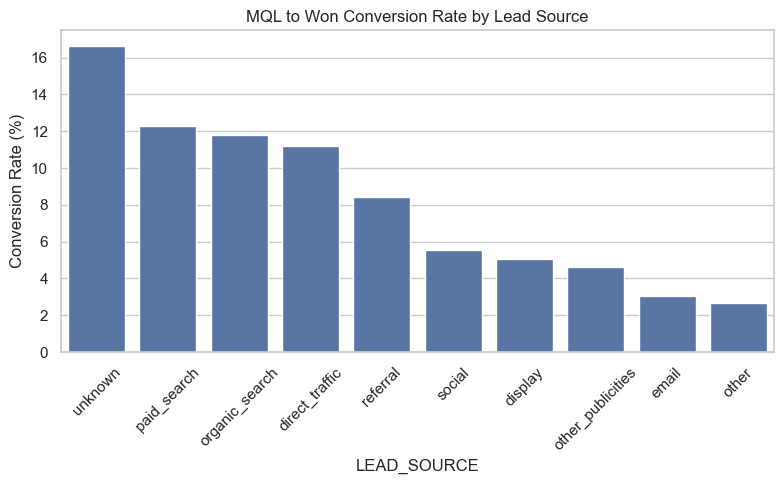

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

sns.barplot(data=df_conversion_rates, x='LEAD_SOURCE', y='MQL_TO_WON_RATE')
plt.title('MQL to Won Conversion Rate by Lead Source')
plt.ylabel('Conversion Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


✅ 1. Bar Plot: Conversion Funnel by Lead Source

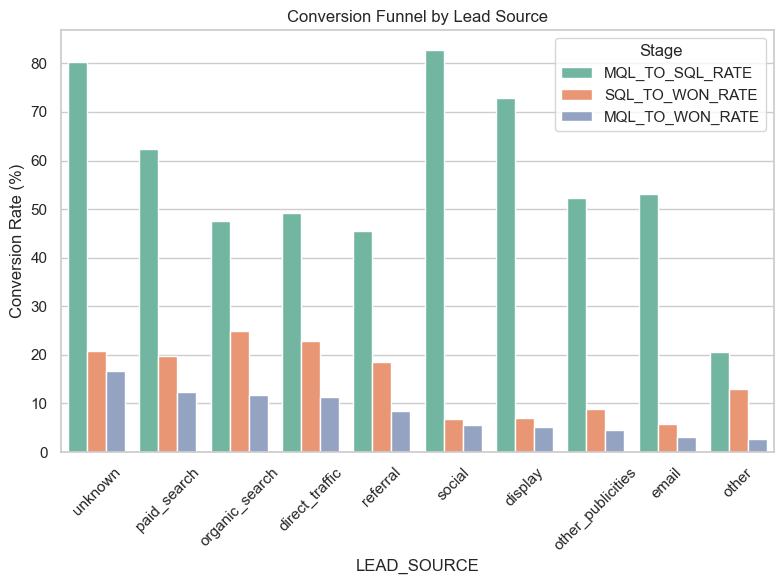

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
df_melted = df_conversion_rates.melt(id_vars='LEAD_SOURCE', 
                                     value_vars=['MQL_TO_SQL_RATE', 'SQL_TO_WON_RATE', 'MQL_TO_WON_RATE'],
                                     var_name='Conversion Stage', 
                                     value_name='Rate')

sns.barplot(data=df_melted, x='LEAD_SOURCE', y='Rate', hue='Conversion Stage', palette='Set2')

plt.title('Conversion Funnel by Lead Source')
plt.ylabel('Conversion Rate (%)')
plt.xticks(rotation=45)
plt.legend(title='Stage')
plt.tight_layout()
plt.show()


✅ 2. Bar Plot: Speed of Conversion (Average Days to Win)

In [96]:
sql_query = "SELECT * FROM mart_first_touch_attribution;"
df_first_att = pd.read_sql(sql_query, conn)
print(f"shape: {df_first_att.shape}")
df_first_att

C:\Users\BETAN\AppData\Local\Temp\ipykernel_5816\2614236048.py:2: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



shape: (10, 5)


,LEAD_SOURCE,TOTAL_LEADS,TOTAL_WON_LEADS,WIN_RATE,AVG_DAYS_TO_WIN
0,unknown,1159,193,16.65,41.9
1,paid_search,1586,195,12.30,56.6
2,organic_search,2296,271,11.80,50.0
3,direct_traffic,499,56,11.22,31.1
4,referral,284,24,8.45,32.5
5,social,1350,75,5.56,61.0
6,display,118,6,5.08,10.3
7,other_publicities,65,3,4.62,39.3
8,email,493,15,3.04,52.2
9,other,150,4,2.67,15.3


C:\Users\BETAN\AppData\Local\Temp\ipykernel_5816\1061664662.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




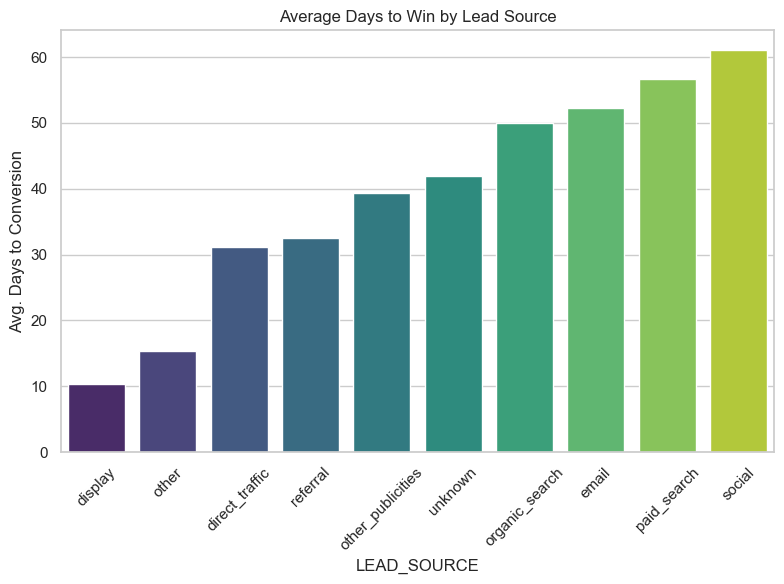

In [91]:
df_fatt_sorted = df_first_att.sort_values(by='AVG_DAYS_TO_WIN', ascending=True)
plt.figure(figsize=(8, 6))
sns.barplot(data=df_fatt_sorted, x='LEAD_SOURCE', y='AVG_DAYS_TO_WIN', palette='viridis')
plt.title('Average Days to Win by Lead Source')
plt.ylabel('Avg. Days to Conversion')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

✅ 3. Scatter Plot: Conversion Rate vs Speed (Bubble Plot)


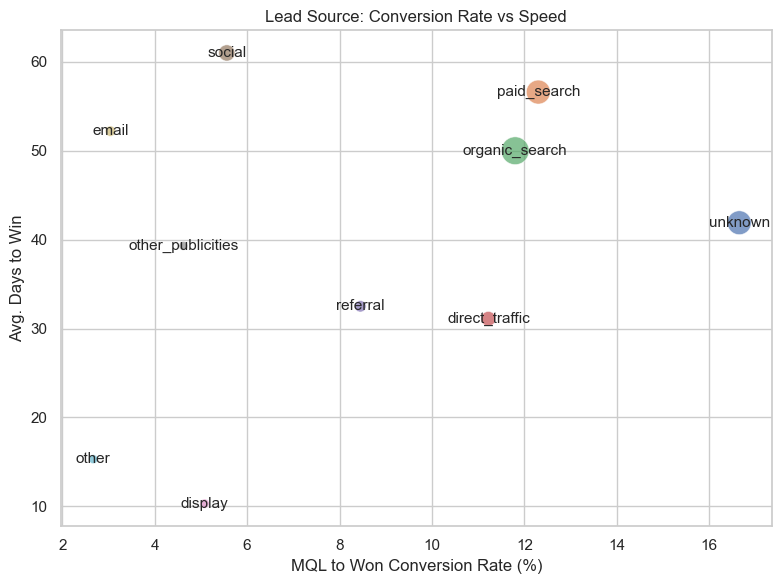

In [107]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_conversion_rates,
    x='MQL_TO_WON_RATE',
    y=df_first_att["AVG_DAYS_TO_WIN"],
    size='TOTAL_WONS',
    hue='LEAD_SOURCE',
    sizes=(40, 400),
    alpha=0.7,
    legend=False
)

# Add labels to each point
for i in range(len(df_conversion_rates)):
    plt.text(
        x=df_conversion_rates['MQL_TO_WON_RATE'][i],
        y=df_first_att['AVG_DAYS_TO_WIN'][i],
        s=df_conversion_rates['LEAD_SOURCE'][i],
        fontsize=11,
        ha='center',
        va='center'
    )

plt.title('Lead Source: Conversion Rate vs Speed')
plt.xlabel('MQL to Won Conversion Rate (%)')
plt.ylabel('Avg. Days to Win')
plt.grid(True)
plt.tight_layout()
plt.show()


✅ 4. Heatmap/Table of All Key Metrics

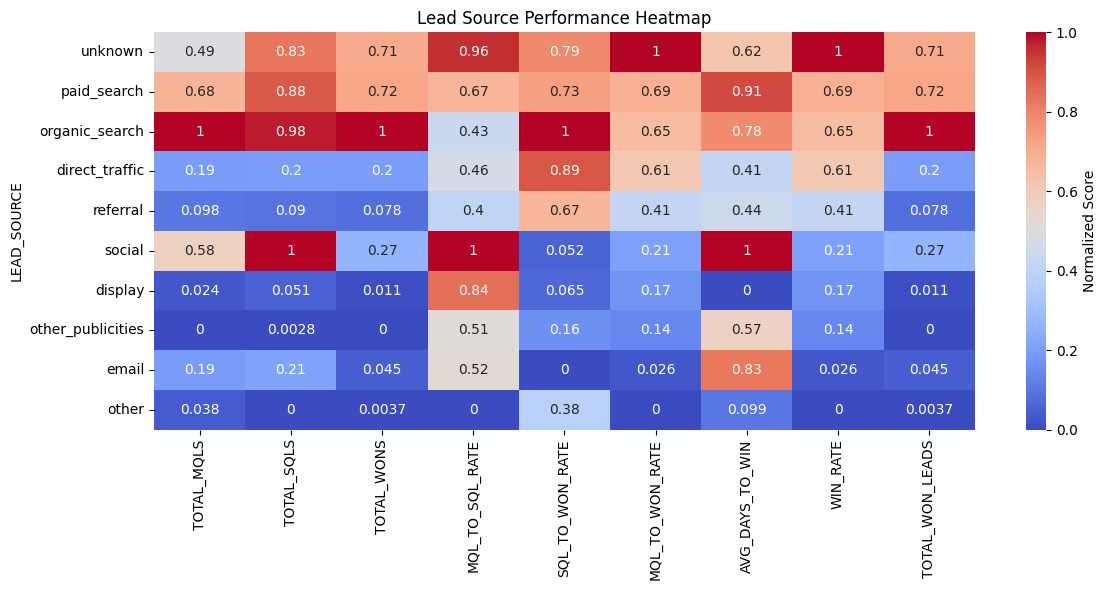

In [ ]:
# Join key metrics for heatmap
df_heatmap = df_conversion_rates.merge(df_first_att[['LEAD_SOURCE', 'AVG_DAYS_TO_WIN', 'WIN_RATE', 'TOTAL_WON_LEADS']],
                                       on='LEAD_SOURCE', how='left')

# Normalize for heatmap
df_norm = df_heatmap.drop(columns=['LEAD_SOURCE']).set_index(df_heatmap['LEAD_SOURCE'])
df_norm_scaled = (df_norm - df_norm.min()) / (df_norm.max() - df_norm.min())

plt.figure(figsize=(12, 6))
sns.heatmap(df_norm_scaled, annot=True, cmap='coolwarm', cbar_kws={'label': 'Normalized Score'})
plt.title('Lead Source Performance Heatmap')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


✅ BONUS: Plot Conversion Time by Lead Type (from df_avg_conv)

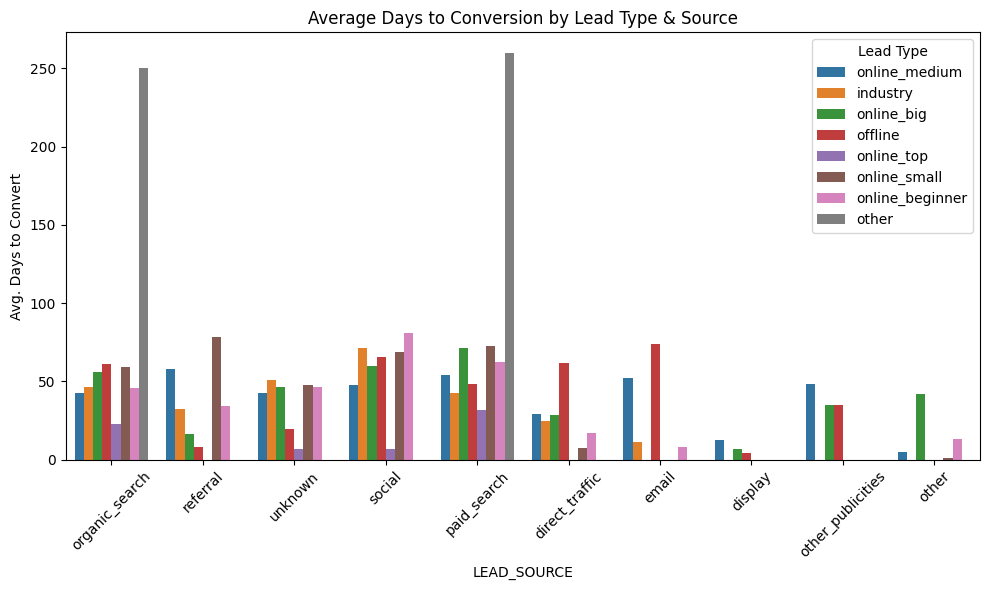

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_avg_conv, x='LEAD_SOURCE', y='AVG_DAYS_TO_CONVERSION', hue='LEAD_TYPE')
plt.title('Average Days to Conversion by Lead Type & Source')
plt.ylabel('Avg. Days to Convert')
plt.xticks(rotation=45)
plt.legend(title='Lead Type')
plt.tight_layout()
plt.show()


✅ 1. Win Rate vs. Avg Days to Win (Best Channels Highlighted)

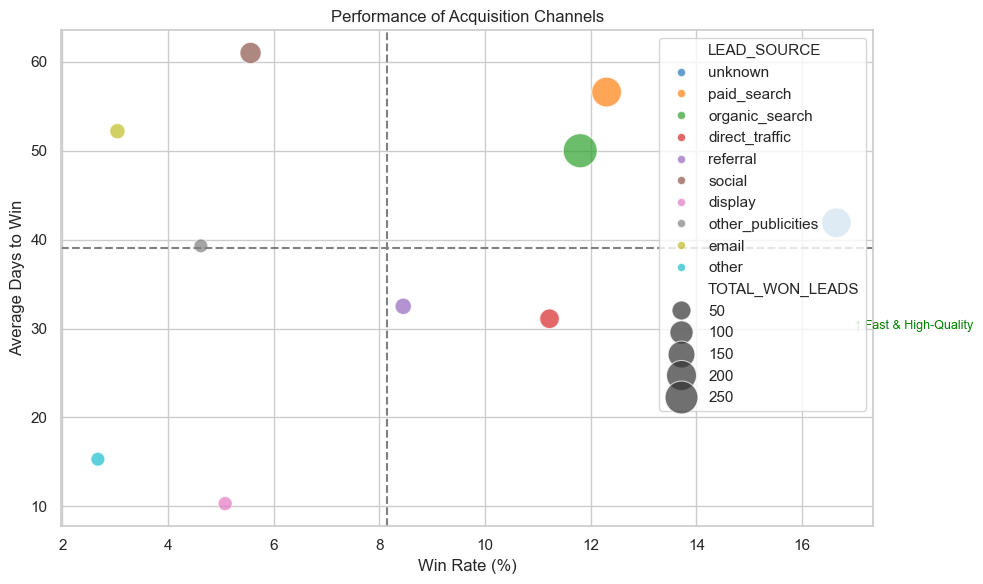

In [102]:

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_first_att,
    x='WIN_RATE',
    y='AVG_DAYS_TO_WIN',
    hue='LEAD_SOURCE',
    size='TOTAL_WON_LEADS',
    sizes=(100, 600),
    alpha=0.7,
    palette='tab10'
)
plt.title('Performance of Acquisition Channels')
plt.xlabel('Win Rate (%)')
plt.ylabel('Average Days to Win')
plt.axhline(y=df_first_att['AVG_DAYS_TO_WIN'].mean(), linestyle='--', color='gray')
plt.axvline(x=df_first_att['WIN_RATE'].mean(), linestyle='--', color='gray')
plt.text(17, 30, '↑ Fast & High-Quality', fontsize=9, color='green')
plt.tight_layout()
plt.show()


# 🐍 Python Code to Estimate ROI

In [114]:
df_first_att

,LEAD_SOURCE,TOTAL_LEADS,TOTAL_WON_LEADS,WIN_RATE,AVG_DAYS_TO_WIN
0,unknown,1159,193,16.65,41.9
1,paid_search,1586,195,12.30,56.6
2,organic_search,2296,271,11.80,50.0
3,direct_traffic,499,56,11.22,31.1
4,referral,284,24,8.45,32.5
5,social,1350,75,5.56,61.0
6,display,118,6,5.08,10.3
7,other_publicities,65,3,4.62,39.3
8,email,493,15,3.04,52.2
9,other,150,4,2.67,15.3


         LEAD_SOURCE  TOTAL_LEADS  TOTAL_WON_LEADS  REVENUE    COST  \
0            unknown         1159              193    96500       0   
1        paid_search         1586              195    97500  158600   
2     organic_search         2296              271   135500   22960   
3     direct_traffic          499               56    28000   49900   
4           referral          284               24    12000    7100   
5             social         1350               75    37500   27000   
6            display          118                6     3000    3540   
7  other_publicities           65                3     1500    3250   
8              email          493               15     7500    2465   
9              other          150                4     2000    2250   

      ROI (%)  
0    0.000000  
1  -38.524590  
2  490.156794  
3  -43.887776  
4   69.014085  
5   38.888889  
6  -15.254237  
7  -53.846154  
8  204.259635  
9  -11.111111  


C:\Users\BETAN\AppData\Local\Temp\ipykernel_5816\3063523144.py:42: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




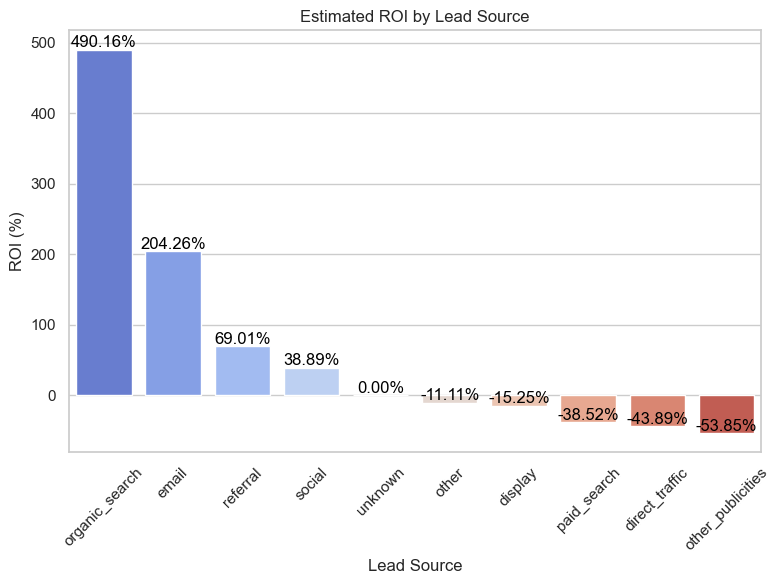

In [122]:
# Use your df_first_att or adjust as needed
df_roi = df_first_att.copy()
# Hypothetical assumptions
average_revenue_per_won = 500  # revenue per Won lead

# Cost per lead by channel (assumed values)
cost_per_lead = {
    'unknown': 0,         # No cost assumed for unknown leads
    'paid_search': 100,   # High cost due to paid ads
    'organic_search': 10, # Lower cost as it comes from organic results
    'referral': 25,       # Referral channels might cost more due to partnerships
    'social': 20,         # Costs associated with social media campaigns
    'email': 5,           # Low cost due to email campaigns
    'display': 30,        # Display ads have moderate costs
    'other_publicities': 50,  # Assumed higher cost for "other" types of publicity
    'other': 15,          # Other miscellaneous sources
    'direct_traffic': 100,  # Direct traffic cost assumed to be 100

}

# Add cost and revenue columns
df_roi['COST'] = df_roi['LEAD_SOURCE'].map(cost_per_lead) * df_roi['TOTAL_LEADS']
df_roi['REVENUE'] = df_roi['TOTAL_WON_LEADS'] * average_revenue_per_won

# Calculate ROI
df_roi['ROI (%)'] = ((df_roi['REVENUE'] - df_roi['COST']) / df_roi['COST']) * 100

# Handle divide-by-zero (e.g., unknown with zero cost)
df_roi['ROI (%)'] = df_roi['ROI (%)'].replace([float('inf'), -float('inf')], 0)

# Display
print(df_roi[['LEAD_SOURCE', 'TOTAL_LEADS', 'TOTAL_WON_LEADS', 'REVENUE', 'COST', 'ROI (%)']])


import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_roi is already sorted
df_roi = df_roi.sort_values(by=['ROI (%)'], ascending=False)

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_roi, x='LEAD_SOURCE', y='ROI (%)', palette='coolwarm')

# Add the ROI values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.title('Estimated ROI by Lead Source')
plt.ylabel('ROI (%)')
plt.xlabel('Lead Source')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [124]:
df_roi[['LEAD_SOURCE','ROI (%)']]

,LEAD_SOURCE,ROI (%)
2,organic_search,490.156794
8,email,204.259635
4,referral,69.014085
5,social,38.888889
0,unknown,0.000000
9,other,-11.111111
6,display,-15.254237
1,paid_search,-38.524590
3,direct_traffic,-43.887776
7,other_publicities,-53.846154
